# 2024-03-06, Day 03

Today we discussed normalisation and variance stabilisation. We started where we left off yesterday: how can we combat the problem that distances mean different things at different regimes?

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# quantile norm

Stefan's answer to the question was quantile normalisation, a technique for making two distributions identical in statistical properties. THis is achieved by sorting all values in the matrix, and then replacing the smallest gene expression value of each cell by the average of all the minimum expression values; the second smallest by the average of all the second-smallest values; and so on. We tried it out. In principle, this should completely avoid the issue (though we could think of edge cases where it could go wrong).

Here is a quick reimplementation:

In [2]:
def quantile_normalize(array_in):
    array = array_in.copy()
    # Sort non-zero values along the gene axis
    sorted_values = np.sort(array, axis=0)
    sorted_indices = np.argsort(array, axis=0)

    # Calculate quantiles along the cell axis
    quantiles = np.mean(sorted_values, axis=1)

    # Replace sorted values in the original array with quantile values
    for i in range(array.shape[1]):
        array[sorted_indices[:, i], i] = quantiles

    return array

In [3]:
adata = sc.datasets.pbmc3k()
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
dense = np.array(adata.X.todense())
adata.obsm["qnorm"] = quantile_normalize(dense)

sc.pp.neighbors(adata, use_rep="qnorm",  metric="cosine", key_added="qnorm")
sc.tl.umap(adata, neighbors_key="qnorm")
adata.obsm["X_umap_qnorm"] = adata.obsm["X_umap"].copy()

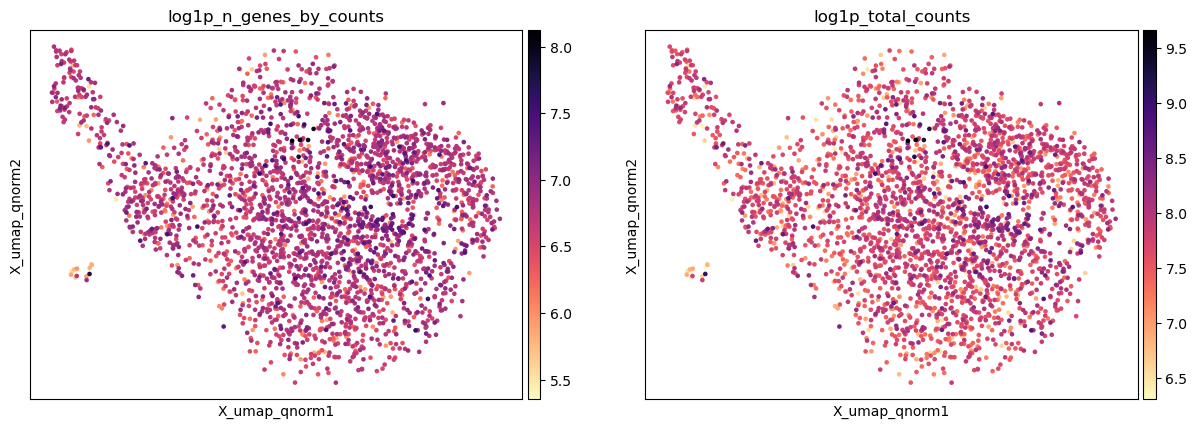

In [5]:
sc.pl.embedding(adata, basis="X_umap_qnorm", color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

It seems that in replacing the gene expression values we lost valuable information. Only a shadow of the dataset's structure remains.

# variance stabilisation

As we got talking about different distance metrics we noticed how they didn't seem to make a very big difference (based on visual inspection of medieval UMAPs). We read a [recent benchmark](https://www.biorxiv.org/content/10.1101/2023.12.26.572833v1.full) of different distance metrics for single-cell RNA-seq data. We discussed how we read papers, we analysed the abstract together, and then took some time to read the manuscript. We then discussed the methods and results. What were they? We also got reminded of the difference between relative and absolute distances, and discussed a bit about what that could mean, and why it could be important.

In reading the paper we noticed that the authors mentioned calculating the distances on "log-normalised" data. This was an epiphany for us: the logarithm is a function that squishes large values considerably, while it squishes small values way less. To apply it to single-cell data we'd need to add a pseudocount to our data, since the logarithm can't deal with 0s.

Before applying it to our data we checked to make sure our intuition was right:

In [6]:
10 - 0

10

In [7]:
np.log1p(10) - np.log1p(0)

2.3978952727983707

In [8]:
20 - 10

10

In [9]:
np.log1p(20) - np.log1p(10)

0.6466271649250523

In [10]:
110 - 100

10

In [11]:
np.log1p(110) - np.log1p(100)

0.09440968447107423

Indeed, the logarithm promises to do what we want from it!

In [12]:
adata = sc.datasets.pbmc3k()
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.normalize_total(adata, target_sum=1000000) # CPM normalisation first

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 12572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

another way to squash higher values more than lower values would be the square root function. What are advantages/disadvantages of both?

In [14]:
sc.pp.log1p(adata)
# adata.X = np.sqrt(adata.X)

In [15]:
sc.pp.neighbors(adata, metric="cosine", use_rep="X")

In [16]:
sc.tl.umap(adata)

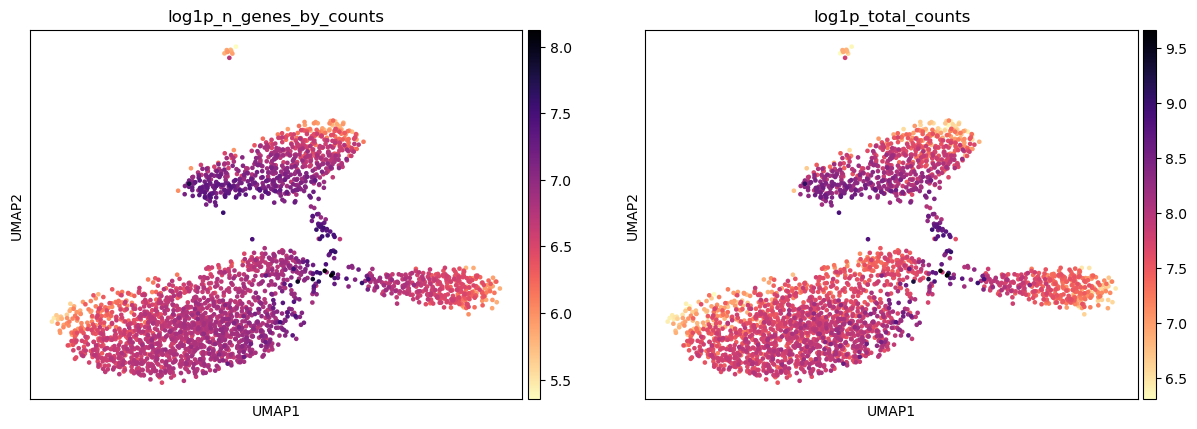

In [17]:
sc.pl.umap(adata, color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

# exploring logarithms

Caution is needed when applying the log-transformation: we are adding counts to the data that weren't there before. While this is not so relevant for highly expressed genes (difference between 100 and 101 counts) it becomes more of an issue for lowly expressed genes (difference between 1 and 2 counts means we are doubling the amount of counts that are there; this would make the gene seem to be expressed in double the magnitude, which is an enormous amount). We explored the structure of the data in slightly more detail to get an intuition about what happens:

In [18]:
adata = sc.datasets.pbmc3k()
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [19]:
log_total_raw = np.sum(np.log1p(adata.X), axis=1)

In [20]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [21]:
log_total_norm = np.sum(adata.X, axis=1)

the `seaborn` library contains nice functions for visualisations we might use often, like histograms, violin plots, or heatmaps.

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

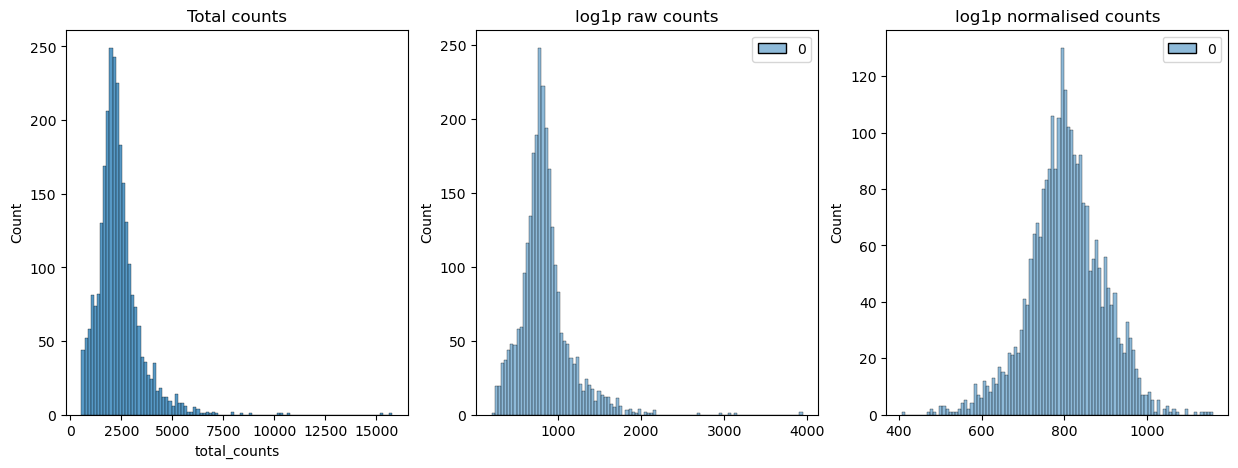

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, ax=axes[0])
axes[0].set_title("Total counts");
p2 = sns.histplot(log_total_raw, bins=100, ax=axes[1])
axes[1].set_title("log1p raw counts");
p3 = sns.histplot(log_total_norm, bins=100, ax=axes[2])
axes[2].set_title("log1p normalised counts");

Just the log-transform already changes how the data looks like, but the shape of the distribution is still mostly the same. However, normalisation and log-transformation changes the shape of the distribution dramatically, to something that looks a lot more Gaussian.

# home-brewed z-score

maybe another way to overcome the variance problem would be to transform the data into standard deviations from the average expression.

$z = \frac{x - \mu}{\sigma}$

In [24]:
adata = sc.datasets.pbmc3k()
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [25]:
dense = np.array(adata.X.todense())

In [26]:
means = np.array(np.mean(adata.X, axis=0))[0]
sigma = np.std(adata.X.toarray(), axis=0)

In [27]:
z = (dense - means) / sigma

In [28]:
adata.obsm["zscore"] = z

In [ ]:
sc.pp.neighbors(adata, use_rep="zscore", metric="cosine")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["log1p_n_genes_by_counts", "log1p_total_counts"], cmap="magma_r")

then again, maybe not :P